### Etiquetado Gramatical

Como primer paso importar desde wikipedia datos para realizar el etiquetado (PoS Tagging).

Codigo obtenido de: [Laboratorio 2 PLN](https://github.com/pln-fing-udelar/intropln2013-lab2/blob/master/lab_entrega2.ipynb)

In [6]:
from glob import glob
from codecs import open, BOM_UTF8 
  
def wikicorpus(words=1000000, start=0):
    s = [[]]
    i = 0
    for f in glob("tagged.es/*")[start:]:
        for line in open(f, encoding="latin-1"):
            if line == "\n" or line.startswith((
              "<doc", "</doc>", "ENDOFARTICLE", "REDIRECT",
              "Acontecimientos", 
              "Fallecimientos", 
              "Nacimientos")):
                continue
            w, lemma, tag, x = line.split(" ")
            if tag.startswith("Fp"):
                tag = tag[:3]
            elif tag.startswith("V"):  # VMIP3P0 => VMI
                tag = tag[:3]
            elif tag.startswith("NC"): # NCMS000 => NCS
                tag = tag[:2] + tag[3]
            else:
                tag = tag[:2]
            for w in w.split("_"): # Puerto_Rico
                s[-1].append((w, tag)); i+=1
            if tag == "Fp" and w == ".":
                s.append([])
            if i >= words:
                return s[:-1]

In [7]:
corpus = wikicorpus()

In [8]:
import random
elegir10 = random.sample(range(len(corpus)), int(len(corpus)*.1))
testing = [corpus[i] for i in elegir10]
training = [corpus[i] for i in range(len(corpus)) if i not in elegir10]

In [9]:
from nltk.tag import BigramTagger, DefaultTagger, RegexpTagger, TrigramTagger, UnigramTagger

patterns = [
      (r'(\w*ado$)|(\w*ada$)|(\w*ido$)|(\w*ida$)|(\w*ito$)|(\w*ita$)|(\w*ota$)|(\w*ote$)|(\w*ense$)|(\w+oso$)|(\w+osa$)', 'A'), # adjetivos
      (r'(\w*ico$)|(\w*aco$)|(\w*aca$)|(\w*ble$)|(\w*cida$)|(\w*dero$)|(\w*dera$)|(\w*dizo$)|(\w*diza$)|(\w*eco$)', 'A'),      
      (r'(\w*ados$)|(\w*adas$)|(\w*idos$)|(\w*idas$)|(\w*itos$)|(\w*itas$)|(\w*otas$)|(\w*otes$)|(\w*enses$)|(\w+osos$)|(\w+osas$)', 'A'), # adjetivos en plural
      (r'(\w*icos$)|(\w*acos$)|(\w*acas$)|(\w*bles$)|(\w*cidas$)|(\w*deros$)|(\w*deras$)|(\w*dizos$)|(\w*dizas$)|(\w*ecos$)', 'A'),
      (r'(\w*cion$)|(\w*azgo$)|(\w*bilidad$)|(\w*encia$)|(\w*ería$)', 'N'), # nombre 
      (r'(\w*aje$)|(\w*al$)|(\w*algia$)|(\w*ancia$)|(\w*anza$)|(\w*ato$)|(\w+era$)|(\w*ero$)|(\w*tud$)', 'N'),
      (r'(\w*dad$)|(\w*dor$)|(\w*dora$)|(\w*eza$)|(\w*ismo$)', 'N'),
      (r'(\w*ciones$)|(\w*azgos$)|(\w*bilidades$)|(\w*encias$)|(\w*erías$)', 'N'), # nombres en plural
      (r'(\w*ajes$)|(\w*ales$)|(\w*algias$)|(\w*ancias$)|(\w*anzas$)|(\w*atos$)|(\w+eras$)|(\w*eros$)|(\w*tudes$)', 'N'),
      (r'(\w*dades$)|(\w*dores$)|(\w*doras$)|(\w*ezas$)|(\w*ismos$)', 'N'),
      (r'(\w*ar$)|(\w*er$)|(\w*ir$)|(\w*mos$)', 'V'), # verbos
      (r'(\w*ando$)|(\w*endo$)', 'V'),                # gerundio
      (r'.*', None)                                   # none (default)
]

regexp_tagger = RegexpTagger(patterns)

dt = DefaultTagger('N')

ut = UnigramTagger(train=training, backoff=regexp_tagger)
bt = BigramTagger(train=training, backoff=ut)
tt = TrigramTagger(train=training, backoff=bt)

### Wordnet

Importar datos de Wordnet para utilizar sinónimos:

In [46]:
from nltk.corpus import WordNetCorpusReader
import nltk.data
wncr = WordNetCorpusReader('wordnet_spa', [])

In [3]:
from nltk import word_tokenize
from nltk.stem.snowball import SpanishStemmer
import operator
from scipy.spatial.distance import cosine


ss = SpanishStemmer()

def tokenize(oracion):
    res = []
    for (palabra, tag) in tt.tag(word_tokenize(oracion)):
        if tag != None:
            if tag.startswith(u'N'):
                res += list(set([synset.name().split(".")[0] for synset in wncr.synsets(palabra, wncr.NOUN)]))
            elif tag.startswith(u'A'):
                res += list(set([synset.name().split(".")[0] for synset in wncr.synsets(palabra, wncr.ADJ)]))
            elif tag.startswith(u'V'):
                res.append(ss.stem(palabra))
    return res


def imprimir_similares(vectores, similar, similitud):
    cant_top = 5
    mostrados = set()
    for top_i, valor_similitud in sorted(similitud.iteritems(), key=operator.itemgetter(1), reverse=True):
        if similar[top_i] in mostrados and similar[similar[top_i]] == top_i:
            continue
        mostrados.add(top_i)
        print len(mostrados), (oraciones[top_i], oraciones[similar[top_i]], valor_similitud)
        if len(mostrados) >= cant_top:
            break


In [4]:
# Cargado de letras en una lista:
import json
from nltk.tokenize import sent_tokenize
f = json.load(open('data/clean/works.json'))
oraciones=[]
for w in f:
    if len(w['lyric']):
        texto = ''
        for verso in w['lyric']:
            for linea in verso:
                texto += unicode(linea.replace('\r\n','') + ' ')
        oraciones.append(texto)


### Cálculo de Similitud 

Generado de vectores para las letras utilizando Tf-Idf, luego cálculo de similtudes entre los vectores

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
transf = TfidfVectorizer(encoding=u'unicode', tokenizer=tokenize)#, strip_accents=u'unicode')
vectores = transf.fit_transform(oraciones)

In [25]:
import numpy as np
similitud = {}
v = (vectores * vectores.T).A
v[np.diag_indices_from(v)] -= 1
j = 0
for i in v.argmax(axis=0):
    similitud[j] = v[j][i]
    j+=1
imprimir_similares(vectores, v.argmax(axis=0), similitud)

1 (u'Hoy que pis\xe9 los cuarenta, hago mi medio balance y no hay tinta que me alcance para escribir sobre vos, decir lo poco que sos, decir lo que fuiste cuando a mi lado viviste jug\xe1ndome una traici\xf3n. Hoy que pis\xe9 los cuarenta yo vuelvo a ser la que fui porque a tiempo descubr\xed, \xa1si hasta verg\xfcenza me da!, que perd\xed la libertad, mi tesoro m\xe1s preciado, quemando horas a tu lado, ignorando la verdad. Hoy que pis\xe9 los cuarenta Y hago mi medio balance, empiezo un nuevo romance con las cosas de la vida, las que cerrar\xe1n la herida que me dej\xf3 tu traici\xf3n. ', u'Hoy que pis\xe9 los cuarenta, hago mi medio balance y no hay tinta que me alcance para escribir sobre vos, decir lo poco que sos, decir lo que fuiste cuando a mi lado viviste jug\xe1ndome una traici\xf3n. Hoy que pis\xe9 los cuatenta yo vuelvo a ser la que fui porque a tiempo descubr\xed, \xa1Si hasta verg\xfcenza me da!, que perd\xed la libertad, mi tesoro m\xe1s preciado, quemando horas a tu lad

### Clusters

Generación de Clusters utilizando Spectral Clustering de los vectores recién calculados

In [26]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=15) # ? n_clusters
#clusters = clustering.fit_transform(vectores.toarray())
predicciones = clustering.fit_predict(vectores.toarray())
print predicciones

[ 6  0 13 ..., 14 12 14]


In [14]:
clusters = []
for i in range(clustering.n_clusters):
    clusters.append([])
for i, c in zip(range(len(predicciones)), predicciones):
    clusters[c].append(i)
for i, cluster in zip(range(1, len(clusters)+1), clusters):
    print i, cluster, '\n'

1 [39, 84, 89, 95, 111, 115, 117, 141, 182, 193, 218, 276, 281, 297, 330, 354, 387, 430, 433, 436, 444, 447, 455, 460, 469, 471, 484, 511, 514, 520, 531, 555, 567, 576, 579, 589, 633, 706, 709, 712, 743, 758, 759, 779, 858, 861, 921, 924, 933, 964, 994, 1001, 1003, 1007, 1031, 1063, 1088, 1094, 1108, 1154, 1157, 1209, 1217, 1231, 1248, 1298, 1302, 1303, 1312, 1314, 1328, 1331, 1342, 1351, 1362, 1370, 1375, 1418, 1483, 1499, 1524, 1536, 1544, 1556, 1566, 1594, 1616, 1629, 1635, 1644, 1645, 1654, 1685, 1705, 1727, 1745, 1751, 1754, 1771, 1793, 1795, 1796, 1833, 1839, 1845, 1855, 1877, 1879, 1892, 1900, 1903, 1950, 1963, 2000, 2002, 2015, 2016, 2032, 2053, 2054, 2056, 2070, 2117, 2125, 2148, 2156, 2184, 2210, 2235, 2250, 2273, 2288, 2293, 2317, 2367, 2370, 2372, 2389, 2404, 2412, 2437, 2459, 2466, 2483, 2494, 2518, 2542, 2553, 2587, 2588, 2654, 2678, 2681, 2694, 2701, 2706, 2730, 2781, 2783, 2824, 2830, 2841, 2855, 2867, 2881, 2882, 2924, 2945, 2953, 2960, 2962, 2986, 2988, 3018, 3023, 30

In [ ]:
print oraciones[9]
print "-----------"
print oraciones[28]

Rechiflado en mi tristeza, te evoco y veo que has sido en mi pobre vida paria sólo una buena mujer. Tu presencia de bacana puso calor en mi nido, fuiste buena, consecuente, y yo sé que me has querido como no quisiste a nadie, como no podrás querer. Se dio el juego de remanye cuando vos, pobre percanta, gambeteabas la pobreza en la casa de pensión. Hoy sos toda una bacana, la vida te ríe y canta, Ios morlacos del otario los jugás a la marchanta como juega el gato maula con el mísero ratón. Hoy tenés el mate lleno de infelices ilusiones, te engrupieron los otarios, las amigas y el gavión; la milonga, entre magnates, con sus locas tentaciones, donde triunfan y claudican milongueras pretensiones, se te ha entrado muy adentro en tu pobre corazón. Nada debo agradecerte, mano a mano hemos quedado; no me importa lo que has hecho, lo que hacés ni lo que harás... Los favores recibidos creo habértelos pagado y, si alguna deuda chica sin querer se me ha olvidado, en la cuenta del otario que tenés 

### Clusters II

Clustering utilizando un nuevo PoS Tagger, basado en Kmeans

In [32]:

from pattern.es     import tag
from pattern.vector import Document, Model, KMEANS, stem

docs = []
i = 0
for s in oraciones:
    v = tag(s)
    res = []
    for (word, pos) in tag(s):
        if pos != None:
            if pos == 'NN':
                res += list(set([synset.name().split(".")[0] for synset in wncr.synsets(word, wncr.NOUN)]))
            elif pos == 'JJ':
                res += list(set([synset.name().split(".")[0] for synset in wncr.synsets(word, wncr.ADJ)]))
            elif pos == 'VB':
                res.append(ss.stem(palabra))
    docs.append(Document(res, name=i))
    i+=1

In [33]:
from pattern.vector import COSINE
m = Model(docs)
c = m.cluster(method=KMEANS, k=15, distance=COSINE)

In [48]:
# Número de letras por cluster
for i, cluster in zip(range(1, len(c)+1), c):
    #print i, [d.name for d in cluster], '\n'
    print i, len(cluster), '\n'

1 232 

2 286 

3 256 

4 176 

5 569 

6 250 

7 402 

8 452 

9 166 

10 448 

11 300 

12 182 

13 405 

14 553 

15 970 



### Visualizacion de los resultados

Reducción de dimansionalidad utilizando T-SNE, para obtener representacion en 2 dimensiones. 


In [22]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2)
data2d = tsne.fit_transform(vectores.toarray() )

### Clusters utiliando Spectral Clustering

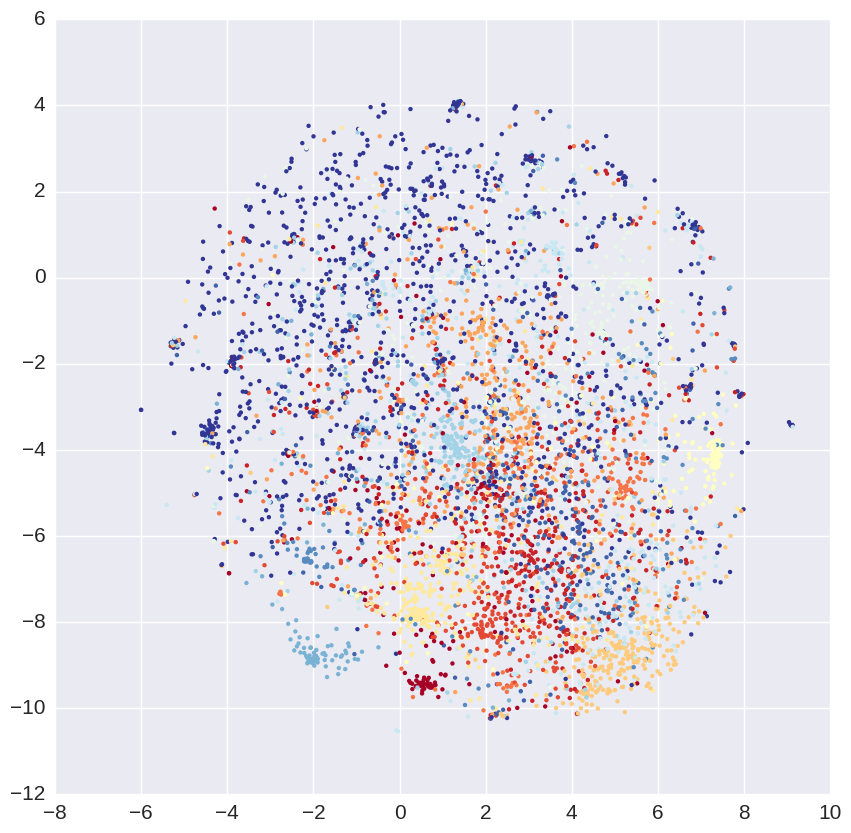

In [31]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.figure(figsize=(10,10))
plt.scatter(data2d[:,0], data2d[:,1], c=predicciones, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 

### Clusters utilizando Kmeans

In [43]:
pred = [0] * len(predicciones)

for i, cluster in zip(range(1, len(c)+1), c):
    for j in cluster:
        pred[j.name] = i


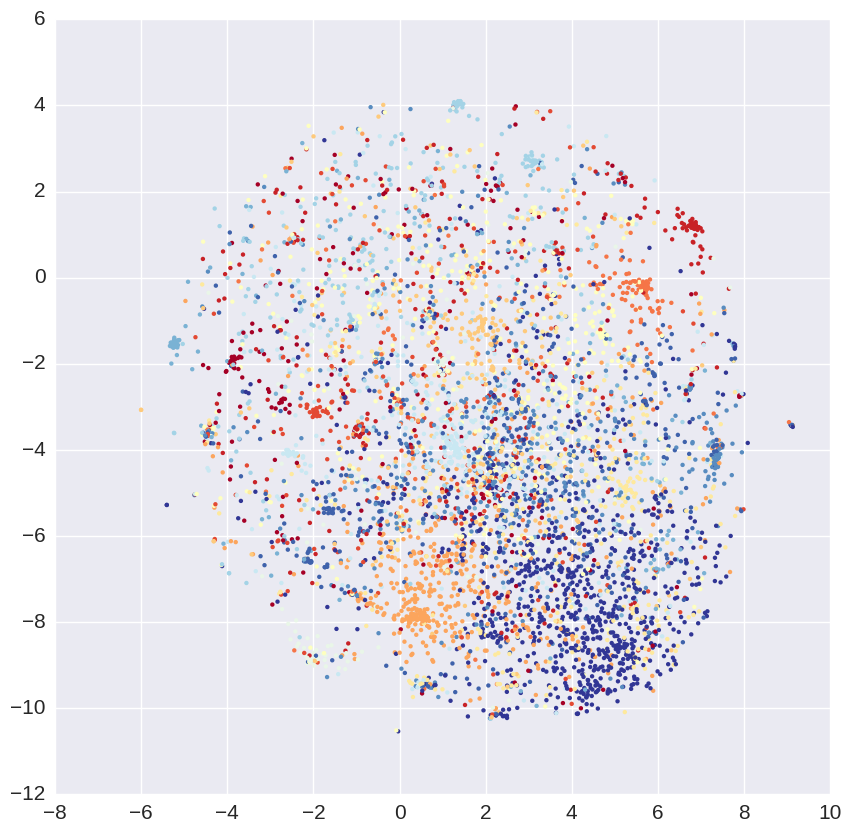

In [44]:

plt.figure(figsize=(10,10))
plt.scatter(data2d[:,0], data2d[:,1], c=pred, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 